In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import radians, cos, sin, asin, sqrt

In [2]:
class BoundingBox(object):
    
    def __init__(self, lat_min, lat_max, long_min, long_max):
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.long_min = long_min
        self.long_max = long_max
        
    def contains(self, lat, long):
        return self.lat_min <= lat <= self.lat_max and self.long_min <= long <= self.long_max

In [3]:
class BoundingBoxSet(object):
    
    def __init__(self, boxes=[]):
        self.boxes = boxes
        
    def init_from_histogram(self, h, xedges, yedges, tolerance):
        """
        consumes h, xedged, yedges variables provided by matplotlib.pyplot.hist2d
        and constructs the bounding boxes according to the specified tolerance
        """
        
        if len(self.boxes) > 0:
            warnings.warn("BoundingBoxSet has been previously initialized, setting self.boxes = []")
            self.boxes = []
        
        rows = h.shape[0]
        cols = h.shape[1]
        
        for row in range(rows):
            for col in range(cols):
                if h[row][col] > tolerance:
                    long_min = xedges[row]
                    long_max = xedges[row+1]
                    lat_min = yedges[col]
                    lat_max = yedges[col+1]

                    self.boxes.append(BoundingBox(lat_min, lat_max, long_min, long_max))


In [4]:
def check_location_against_bbox_set(row, bbox_set):
    """
    Check if a provided location is contained in any of the boundingboxes
    Return true if it is, flase otherwise
    """
    
    for box in bbox_set.boxes:
        if box.contains(row['gpslat'], row['gpslong']):
            return True  
    return False

In [5]:
def check_tolerances_dataset(data, bbox_set):
    data.loc[:, 'is_in_tolerance_area'] = data.apply(check_location_against_bbox_set, args=[bbox_set], axis=1)
    return data

In [6]:
def build_sample_indices(data, col):
    """
    Builds sequence indices based on duration data
    Iterate over the rows in data and increment index whenever duration == 0
    
    Args:
        data (pd.DataFrame) : The dataframe whose indices are to be built.
        col (string) : The column of the dataframe with respect to the indexing
    Returns:
         data (pd.Series) : Data with an added column for the sequence indices
    """
    
    idx = 0
    seq_indices = []
    for _, row in data.iterrows():
        if row[col] == 0:
            #increment index and begin new sequence
            idx += 1
            seq_indices.append(idx)
        else:
            seq_indices.append(idx)
    
    data['sequence'] = seq_indices
    
    return data

In [7]:
def drop_sequences(data, cond_col, condition, threshold):
    """
    Drop sequences including > threshold rows where the column
    cond_col evaluates to condition
    
    Args:
        data (pd.DataFrame) : data to be checked
        cond_col (string) : the name of the column to be checked for a logical condition
        condition (bool) : The condition
        threshold (int) : occurence threshold for removing the sequence
    Returns:
        data_dropped (pd.DataFrame) : data where the affected rows have been dropped
    """
    seq_ids = list(data['sequence'].unique())
    to_be_dropped = []
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        try:
            if seq[cond_col].value_counts()[condition] > threshold:
                to_be_dropped.append(seq.index.tolist())
        except:
            pass
        
    to_be_dropped = [idx for seq in to_be_dropped for idx in seq]
    data_dropped = data.drop(to_be_dropped) 
    return data_dropped


In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """
    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r


In [9]:
def compute_distance_between_rows(row1, row2, gpslat_col, gpslong_col):
    """
    Compute the haversine distance given two rows sliced from a pd.DataFrame.
    Rows are expected to be identical in their columns
    
    Args:
        row1 (pd.Series of shape (1, n_features)) 
        row2 (pd.Series of shape (1, n_features))
        gpslat_col (string) : the identifier of the column of gps latitude in both rows
        gpslong_col (string) : the identifier of the column of gps longitude in both rows
    
    Returns:
        distance (float)
    """
    lon1 = row1[gpslong_col]
    lat1 = row1[gpslat_col]
    lon2 = row2[gpslong_col]
    lat2 = row2[gpslat_col]
        
    return haversine(lon1, lat1, lon2, lat2)


In [10]:
def convert_sequence_to_relative(seq):
    """
    Converts gpslat, gpslong and altitude to running relative metrics
    
    Args:
        seq (pd.DataFrame) : the sequence to be converted
    
    Returns:
        distance (pd.Series) : running distance offset (meters) from the beginning of the series
        rel_altitude (pd.Series) : running altitude offset (meters) from the beginning of the series
        rel_soc (pd.Series) : the additive inverse of SOC offset from beginning of the series
    """
    first_row = seq.iloc[0,:]
    args = (first_row, 'gpslat', 'gpslong')
    
    distance = seq.apply(compute_distance_between_rows, args=args, axis=1)
    rel_altitude = seq.apply(lambda row : row['altitude'] - first_row['altitude'], axis=1)
    rel_soc = seq.apply(lambda row : -1*(row['soc'] - first_row['soc']), axis=1)
    
    return distance, rel_altitude, rel_soc


In [11]:
def convert_dataset_to_relative(data):
    """
    Iterate over sequences in the whole dataset and make the necessary conversions
    """
    seq_ids = list(data['sequence'].unique())
    
    for seq_id in seq_ids:
        seq = data[data['sequence'] == seq_id]
        distance, rel_altitude, rel_soc = convert_sequence_to_relative(seq)
        data.loc[seq.index, 'distance'] = distance
        data.loc[seq.index, 'rel_altitude'] = rel_altitude
        data.loc[seq.index, 'rel_soc'] = rel_soc
    
    data = data.drop(['gpslat', 'gpslong', 'altitude', 'soc'], axis=1)
    
    return data


In [12]:
def preprocess_dataset(data, bins, threshold):
    h, xedges, yedges, _ = plt.hist2d(data['gpslong'], data['gpslat'], bins=bins)
    bbox_set = BoundingBoxSet()
    bbox_set.init_from_histogram(h, xedges, yedges, 1)
    
    #Apply transformations
    data = check_tolerances_dataset(data, bbox_set)
    data = build_sample_indices(data, 'duration')
    data = drop_sequences(data, 'is_in_tolerance_area', False, threshold=threshold)
    data = convert_dataset_to_relative(data)
    data = data.drop('is_in_tolerance_area', axis = 1)
    data = data.drop('timestamp', axis = 1)
    
    return data
    

-----------------

In [13]:
data = pd.read_csv('../data/dummy_data.csv')

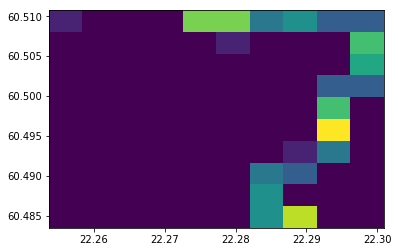

In [14]:
transformed_data = preprocess_dataset(data, 10, 0)

In [15]:
transformed_data

speed      temp  duration  sequence  distance  rel_altitude   rel_soc
11  21.640625 -0.835443         0         2  0.000000      0.000000 -0.000000
12  34.296875 -0.851266         5         2  0.053487     -0.292448  0.200000
13  38.804688 -0.867089        10         2  0.108692     -0.606137  0.360000
14  39.445312 -0.882911        15         2  0.167016     -0.654427  0.400000
15  38.101562 -0.898734        20         2  0.232565     -0.592763  0.350000
16  26.511719 -0.914557        25         2  0.232565     -0.592763  0.286667
17  20.085938 -0.930380        30         2  0.272694     -1.522142  0.253333
18  30.421875 -0.946203        35         2  0.298685     -2.115871  0.420000
19  42.367188 -0.962025        40         2  0.329746     -1.843151  0.720000
20  44.449219 -0.977848        45         2  0.390133     -1.727719  0.820000
21  44.175781 -0.993671        50         2  0.458653     -2.763739  0.903333
22  43.921875 -0.500000        55         2  0.515489     -3.983220  0.970000
23  46.945312 -0.333333        60         2  0.588588     -5.601456  1.030000
24  46.804688 -0.991870        65         2  0.588588     -5.601456  1.080000
25  46.433594 -0.951220        70         2  0.666050     -6.760663  1.136667
26  47.753906 -0.910569        75         2  0.731080     -6.959676  1.220000
27  46.953125 -0.869919         0         3  0.000000      0.000000 -0.000000
28  45.582031 -0.829268         5         3  0.066976      1.756250  0.300000
29  48.062500 -0.788618        10         3  0.147419      3.081889  0.466667
30  49.632812 -0.747967        15         3  0.229593      3.530556  0.660000
31  48.085938 -0.707317        20         3  0.308876      3.930556  0.780000
32  48.121094 -0.666667        25         3  0.308876      3.930556  0.880000
33  45.988281 -0.626016        30         3  0.373158      2.230556  0.966667
34  43.527344 -0.585366         0         4  0.000000      0.000000 -0.000000
35  31.132812 -0.544715         5         4  0.066345      3.192198 -0.160000
36  18.003906 -0.504065        10         4  0.114590      4.533889 -0.300000
37  15.882812 -0.463415        15         4  0.141673      3.982148 -0.297143
38  19.363281 -0.422764        20         4  0.167192      2.844988 -0.220000
39  29.972656 -0.382114        25         4  0.199050      1.815476 -0.123333
40  36.863281 -0.341463        30         4  0.253167     -0.763815 -0.040000
41  40.984375 -0.300813         0         5  0.000000      0.000000 -0.000000
42  43.562500 -0.260163         5         5  0.065700     -2.429225 -0.055556
43  43.781250 -0.219512        10         5  0.141352     -4.912207 -0.080000
44  42.480469 -0.178862        15         5  0.141352     -4.912207  0.005882
45  41.285156 -0.138211        20         5  0.214536     -5.570192  0.035294
46  38.972656 -0.097561        25         5  0.286526     -5.940234  0.064706
47  38.847656 -0.056911         0         6  0.000000      0.000000 -0.000000
48  39.429688 -0.008130         5         6  0.056790      1.152149  0.105882
49  37.476562 -0.800000        10         6  0.122154      2.400149  0.189216
50  36.035156 -0.733333        15         6  0.184925      3.421047  0.365882
51  36.671875 -0.400000        20         6  0.237095      3.885538  0.463025
52  35.085938 -0.066667        25         6  0.287223      3.876420  0.545882
53  35.062500 -0.800000        30         6  0.334781      4.433006  0.625882
54  33.164062 -0.200000        35         6  0.391256      5.095864  0.675882
55  31.589844 -0.041667        40         6  0.437235      5.083165  0.728105
56  33.472656 -0.093750        45         6  0.495324      4.728535  0.783660
57  35.156250 -0.145833        50         6  0.495324      4.728535  0.745882
58  40.042969 -0.197917        55         6  0.545284      4.451822  0.748739
59  38.937500 -0.250000         0         7  0.000000      0.000000 -0.000000
60  32.890625 -0.302083         5         7  0.057628      0.059744 -0.033333
61  25.113281 -0.354167       

In [16]:
data = pd.read_csv('../data/trips_bulk.csv')

In [17]:
data = data[0:100000]

C:\Users\Panu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: BoundingBoxSet has been previously initialized, setting self.boxes = []
  del sys.path[0]


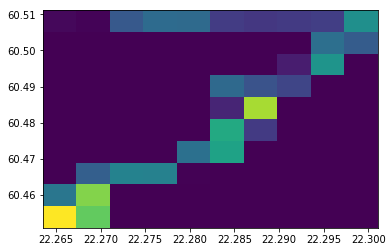

In [18]:
trans_data = preprocess_dataset(data, 10, 0)

In [19]:
trans_data

speed      temp  duration  sequence  distance  rel_altitude  \
0      25.570312 -0.661392         0         1  0.000000      0.000000   
1      27.574219 -0.677215         5         1  0.040666     -0.696062   
2      30.535156 -0.693038        10         1  0.092468     -1.234818   
3      31.160156 -0.708861        15         1  0.142041     -1.711705   
4      34.199219 -0.724684        20         1  0.186323     -3.369781   
5      32.167969 -0.740506        25         1  0.186323     -3.369781   
6      33.433594 -0.756329        30         1  0.227814     -3.107569   
7      35.300781 -0.772152        35         1  0.267211     -3.755753   
8      31.132812 -0.787975        40         1  0.314702     -6.448910   
9      17.683594 -0.803797        45         1  0.363916     -6.762090   
10     12.183594 -0.819620        50         1  0.384286     -6.940597   
11     21.640625 -0.835443        55         1  0.388533     -7.015486   
12     34.296875 -0.851266        60         1  0.385387     -7.307934   
13     38.804688 -0.867089        65         1  0.387095     -7.621623   
14     39.445312 -0.882911        70         1  0.394777     -7.669913   
15     38.101562 -0.898734        75         1  0.409293     -7.608249   
16     26.511719 -0.914557        80         1  0.409293     -7.608249   
17     20.085938 -0.930380        85         1  0.426028     -8.537628   
18     30.421875 -0.946203        90         1  0.459875     -9.131357   
19     42.367188 -0.962025        95         1  0.514575     -8.858637   
20     44.449219 -0.977848       100         1  0.591448     -8.743205   
21     44.175781 -0.993671       105         1  0.669616     -9.779226   
22     43.921875 -0.500000       110         1  0.735102    -10.998707   
23     46.945312 -0.333333       115         1  0.815961    -12.616942   
24     46.804688 -0.991870       120         1  0.815961    -12.616942   
25     46.433594 -0.951220       125         1  0.896631    -13.776149   
26     47.753906 -0.910569       130         1  0.963008    -13.975162   
27     46.953125 -0.869919       135         1  1.043653    -11.419540   
28     45.582031 -0.829268       140         1  1.110063     -9.663290   
29     48.062500 -0.788618       145         1  1.188441     -8.337651   
...          ...       ...       ...       ...       ...           ...   
99970  43.902344  0.039749       110       486  0.666853     -9.670744   
99971  42.707031  0.034519       115       486  0.744553    -11.209266   
99972  41.871094  0.029289       120       486  0.808368    -12.441780   
99973  41.687500  0.024059       125       486  0.808368    -12.441780   
99974  43.585938  0.018828       130       486  0.808368    -12.441780   
99975  46.839844  0.013598       135       486  0.808368    -12.441780   
99976  46.433594  0.008368       140       486  0.808368    -12.441780   
99977  43.199219  0.003138       145       486  0.808368    -12.441780   
99978  42.304688  0.222222       150       486  0.808368    -12.441780   
99979  44.210938  0.777778       155       486  0.808368    -12.441780   
99980  45.003906  0.571429       160       486  0.808368    -12.441780   
99981  44.816406  0.000994       165       486  0.808368    -12.441780   
99982  41.812500  0.005964       170       486  0.808368    -12.441780   
99983  37.945312  0.010934       175       486  0.808368    -12.441780   
99984  34.726562  0.015905       180       486  0.808368    -12.441780   
99985  25.804688  0.020875       185       486  0.808368    -12.441780   
99986  17.824219  0.025845       190       486  0.808368    -12.441780   
99987  18.328125  0.030815       195       486  1.590128    -22.560561   
99988  25.386719  0.035785       200       486  1.590128    -22.560561   
99989  38.601562  0.040755       205       486  1.590128    -22.560561   
99990  42.539062  0.045726       210       486  1.590128    -22.560561   
99991  43.472656  0.050696       215       486  1.590128    -22.560561   
99992  41.18750

In [ ]:
trans_data.to_csv('../data/midsize_dummy_preprocessed.csv', index=False)